In [1]:
pwd

'/data2/mito_lineage/Analysis/multiplex'

In [2]:
AD_F = "../data/mitoDNA/cellSNP.tag.AD.mtx"
DP_F = "../data/mitoDNA/cellSNP.tag.DP.mtx"

In [3]:
# Parameters
AD_F = "data/chrM/PBMC_P_cellSNP_minC20_minAF0.01/cellSNP.tag.AD.mtx"
DP_F = "data/chrM/PBMC_P_cellSNP_minC20_minAF0.01/cellSNP.tag.DP.mtx"


In [4]:
pwd

'/data2/mito_lineage/Analysis/multiplex'

# Using vireo for clonal reconstruction - mitochondrial mutations

The mitochondrial mutations data set is extracted from [Ludwig et al, Cell, 2019](https://doi.org/10.1016/j.cell.2019.01.022), the 9 variants used here are from Supp Fig. 2F (and main Fig. 2F).

For clonal reconstruction, we are using the core class `vireoSNP.Vireo` with multiple initializations

In [5]:
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt

print(vireoSNP.__version__)

0.4.2


In [6]:
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

In [7]:
AD = mmread(AD_F).tocsc()
DP = mmread(DP_F).tocsc()

In [8]:
AD_shape = AD.todense().shape

## New implementation in v0.3.0

In [9]:
from vireoSNP import Vireo

Note, there are a few key parameters:

* `n_donor`: it means number of clones here, but you need to determine yourself. You can choose the one with highest ELBO (see next section)
* `n_GT`: number of different genotype. For somatic mutations, we could assume that there are only two, namely present or absent
* `is_theta_ASE`: whether allelic ratio is variant specific. For mitochondrial mutations, we choose True as allelic ratio can different from variant to variant

### Multiple initialization is needed to avoid local optima

In [10]:
np.random.seed(1)

n_initials = 50
_models_all = []
for i in range(n_initials):
    _modelCA = Vireo(n_var=AD_shape[0], n_cell=AD_shape[1], n_donor=3, n_GT=2,
                     fix_beta_sum=False, ASE_mode=True)
    _modelCA.set_prior(beta_mu_prior=np.array([[0.01, 0.5]]))
    _modelCA.fit(AD, DP, min_iter=20, verbose=False, delay_fit_theta=0)
    _models_all.append(_modelCA)

In [11]:
## Choose the model giving highest ELBO

_idx = np.argmax([x.ELBO_[-1] for x in _models_all])
modelCA = _models_all[_idx]
_losses = modelCA.ELBO_

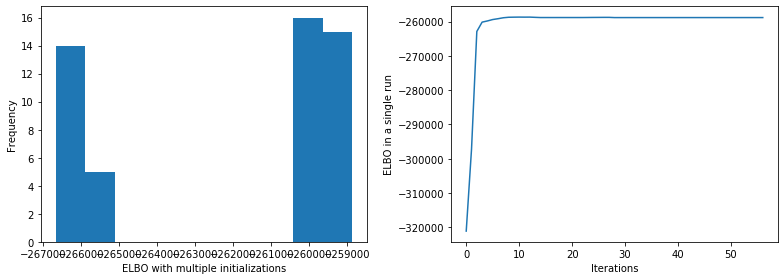

In [12]:
fig = plt.figure(figsize=(11, 4))
plt.subplot(1, 2, 1)
plt.hist([x.ELBO_[-1] for x in _models_all])
plt.ylabel("Frequency")
plt.xlabel("ELBO with multiple initializations")

plt.subplot(1, 2, 2)
plt.plot(_losses)
plt.xlabel("Iterations")
plt.ylabel("ELBO in a single run")

plt.tight_layout()
plt.show()

In [13]:
print(modelCA.beta_mu),
print(modelCA.beta_sum)

[[0.02230 0.02248]
 [0.04915 0.05160]
 [0.03654 0.03847]
 [0.26654 0.29098]
 [0.01388 0.01461]
 [0.01496 0.50000]
 [0.01235 0.01384]
 [0.01570 0.01729]
 [0.01222 0.01299]
 [0.01168 0.01284]
 [0.01358 0.01677]
 [0.14409 0.13057]
 [0.01154 0.01887]
 [0.02053 0.02194]
 [0.01645 0.01792]
 [0.01048 0.50000]
 [0.01027 0.01079]
 [0.01547 0.02240]
 [0.00873 0.01027]
 [0.00713 0.01684]
 [0.00627 0.01485]
 [0.37167 0.46466]
 [0.00982 0.01368]
 [0.13127 0.13652]
 [0.01713 0.01906]
 [0.16158 0.17405]
 [0.02485 0.02626]
 [0.01266 0.01411]
 [0.01501 0.01569]
 [0.14794 0.16543]
 [0.01121 0.01368]
 [0.08368 0.09687]
 [0.06197 0.07312]
 [0.01678 0.02203]
 [0.02054 0.02498]
 [0.01223 0.01492]
 [0.01245 0.01524]
 [0.01281 0.01519]
 [0.01846 0.02814]
 [0.03554 0.03729]
 [0.01369 0.01804]
 [0.00926 0.01092]
 [0.01089 0.01384]
 [0.01172 0.01202]
 [0.00745 0.01239]
 [0.01128 0.02012]
 [0.01492 0.02629]
 [0.02502 0.03963]
 [0.07946 0.09131]
 [0.03473 0.03601]
 [0.01739 0.01954]
 [0.01310 0.01404]
 [0.02501 0.

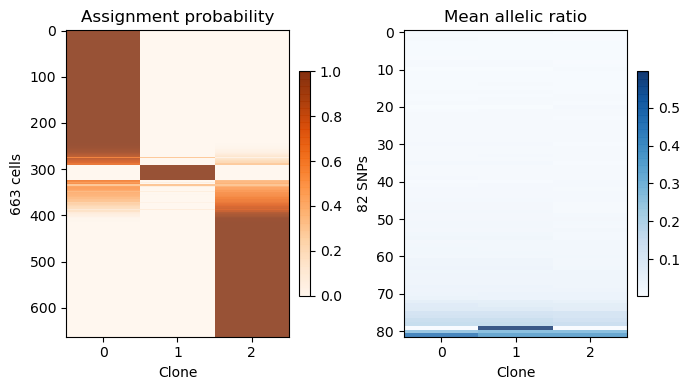

In [14]:
import matplotlib.pyplot as plt
from vireoSNP.plot.base_plot import heat_matrix

fig = plt.figure(figsize=(7, 4), dpi=100)
plt.subplot(1, 2, 1)
im = heat_matrix(modelCA.ID_prob, cmap="Oranges", alpha=0.8,
                 display_value=False, row_sort=True)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Assignment probability")
plt.xlabel("Clone")
plt.ylabel("%d cells" %(modelCA.n_cell))
plt.xticks(range(modelCA.n_donor))


plt.subplot(1, 2, 2)
AF_SNPs = np.sum(modelCA.GT_prob * 
                 np.expand_dims(modelCA.beta_mu, 1), axis=2)
im = heat_matrix(AF_SNPs, cmap="Blues", alpha=0.8, 
                 display_value=False, row_sort=True)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Mean allelic ratio")
plt.xlabel("Clone")
plt.ylabel("%d SNPs" %(modelCA.n_var))
plt.xticks(range(modelCA.n_donor))

plt.tight_layout()
plt.show()

In [15]:
np.sum(modelCA.predict_doublet(AD, DP)[0])

66.84258490200754

### Choose the number of clones
We can choose the number of clones where ELBO stops increasing. Here, the best number of clone is 3.

Note, for a certain number of clone, e.g., n_clone=3, the ELBO may not the same for multiple initializations. This is becaused VI can only guarantee a local optima, so please choose the highest ELBO for each `n_clone` to represent its "global" optima.

In [16]:
n_initials = 50
n_clone_list = np.arange(2, 6)

_ELBO_mat = [] 
for k in n_clone_list:
    _elbo_temp = []
    for i in range(50):
        _modelCA = Vireo(n_var=AD_shape[0], n_cell=AD_shape[1], n_donor=k, n_GT=2,
                         fix_beta_sum=False, ASE_mode=True)
        _modelCA.set_prior(beta_mu_prior=np.array([[0.01, 0.5]]))
        _modelCA.fit(AD, DP, min_iter=20, verbose=False)
        _elbo_temp.append(_modelCA.ELBO_[-1])
    _ELBO_mat.append(_elbo_temp)

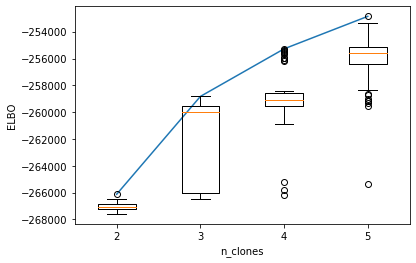

In [17]:
plt.plot([1, 2, 3, 4], np.max(_ELBO_mat, axis=1))
plt.boxplot(_ELBO_mat)
plt.xticks(n_clone_list - 1, n_clone_list)
plt.ylabel("ELBO")
plt.xlabel("n_clones")
plt.show()

## Plot K=4

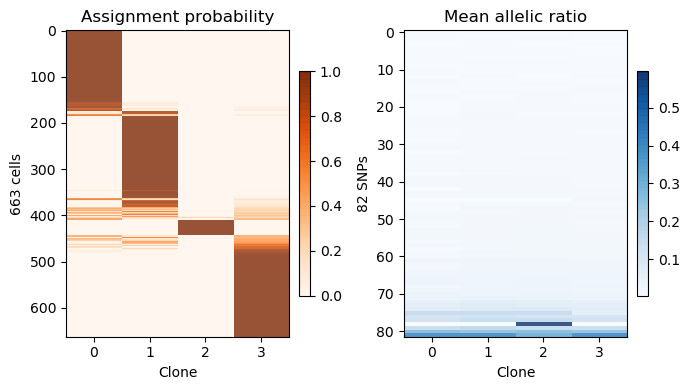

In [23]:
np.random.seed(1)

n_initials = 50
_models_all = []
for i in range(n_initials):
    _modelCA = Vireo(n_var=AD_shape[0], n_cell=AD_shape[1], n_donor=4, n_GT=2,
                     fix_beta_sum=False, ASE_mode=True)
    _modelCA.set_prior(beta_mu_prior=np.array([[0.01, 0.5]]))
    _modelCA.fit(AD, DP, min_iter=20, verbose=False, delay_fit_theta=0)
    _models_all.append(_modelCA)
    
## Choose the model giving highest ELBO

_idx = np.argmax([x.ELBO_[-1] for x in _models_all])
modelCA = _models_all[_idx]
_losses = modelCA.ELBO_


import matplotlib.pyplot as plt
from vireoSNP.plot.base_plot import heat_matrix

fig = plt.figure(figsize=(7, 4), dpi=100)
plt.subplot(1, 2, 1)
im = heat_matrix(modelCA.ID_prob, cmap="Oranges", alpha=0.8,
                 display_value=False, row_sort=True)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Assignment probability")
plt.xlabel("Clone")
plt.ylabel("%d cells" %(modelCA.n_cell))
plt.xticks(range(modelCA.n_donor))


plt.subplot(1, 2, 2)
AF_SNPs = np.sum(modelCA.GT_prob * 
                 np.expand_dims(modelCA.beta_mu, 1), axis=2)
im = heat_matrix(AF_SNPs, cmap="Blues", alpha=0.8, 
                 display_value=False, row_sort=True)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Mean allelic ratio")
plt.xlabel("Clone")
plt.ylabel("%d SNPs" %(modelCA.n_var))
plt.xticks(range(modelCA.n_donor))

plt.tight_layout()
plt.show()